<h1>Análise de Series Temporais - Pantanal</h1>

### Importação de bibliotecas e carregamento de dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
base_dados = pd.read_csv('dados_limpos_v4.csv')

In [3]:
base_dados.head()

,Unnamed: 0,DataHora,Satelite,Pais,Estado,Municipio,Bioma,DiaSemChuva,Precipitacao,RiscoFogo,Latitude,Longitude,Data
0,0,2014-01-01 15:55:00,AQUA_M-T,Brasil,BAHIA,BELMONTE,Mata Atlântica,NaN,0.0,0.0,-15.995,-38.970,2014-01-01
1,1,2014-01-01 15:55:00,AQUA_M-T,Brasil,BAHIA,BELMONTE,Mata Atlântica,NaN,0.0,0.0,-15.993,-38.951,2014-01-01
2,2,2014-01-01 15:56:00,AQUA_M-T,Brasil,BAHIA,MACAJUBA,Caatinga,4.0,0.0,0.8,-12.074,-40.300,2014-01-01
3,3,2014-01-01 15:56:00,AQUA_M-T,Brasil,BAHIA,MACAJUBA,Caatinga,4.0,0.0,0.6,-12.070,-40.296,2014-01-01
4,4,2014-01-01 15:56:00,AQUA_M-T,Brasil,BAHIA,ILHÉUS,Mata Atlântica,4.0,0.0,0.0,-14.931,-39.095,2014-01-01


In [4]:
# Remover a coluna 'Unnamed'
base_dados = base_dados.drop(columns=['Unnamed: 0'])


# Remover as linhas com dados nulos nas colunas 'DiaSemChuva', 'Precipitacao', 'RiscoFogo'
base_dados = base_dados.dropna(subset=['DiaSemChuva', 'Precipitacao', 'RiscoFogo'])

# Converter a coluna 'DataHora' para o formato datetime
base_dados['DataHora'] = pd.to_datetime(base_dados['DataHora'])

In [5]:
# Criando uma sub-base para fins de teste (pegando apenas uma amostra de 1%)
#base_dados = base_dados.sample(frac=0.01, random_state=42)

# Verificando a estrutura da sub-base
print(base_dados.info())
print(base_dados.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1956208 entries, 2 to 1956209
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   DataHora      datetime64[ns]
 1   Satelite      object        
 2   Pais          object        
 3   Estado        object        
 4   Municipio     object        
 5   Bioma         object        
 6   DiaSemChuva   float64       
 7   Precipitacao  float64       
 8   RiscoFogo     float64       
 9   Latitude      float64       
 10  Longitude     float64       
 11  Data          object        
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 194.0+ MB
None
             DataHora  Satelite    Pais Estado Municipio           Bioma  \
2 2014-01-01 15:56:00  AQUA_M-T  Brasil  BAHIA  MACAJUBA        Caatinga   
3 2014-01-01 15:56:00  AQUA_M-T  Brasil  BAHIA  MACAJUBA        Caatinga   
4 2014-01-01 15:56:00  AQUA_M-T  Brasil  BAHIA    ILHÉUS  Mata Atlântica   
5 2014-01-01 15:56:00  AQUA_M-T  B

# 1. Análise de Séries Temporais

## 1.1. Decomposição de Séries Temporais

Decomposição da série temporal da variável de interesse, **RiscoFogo**.

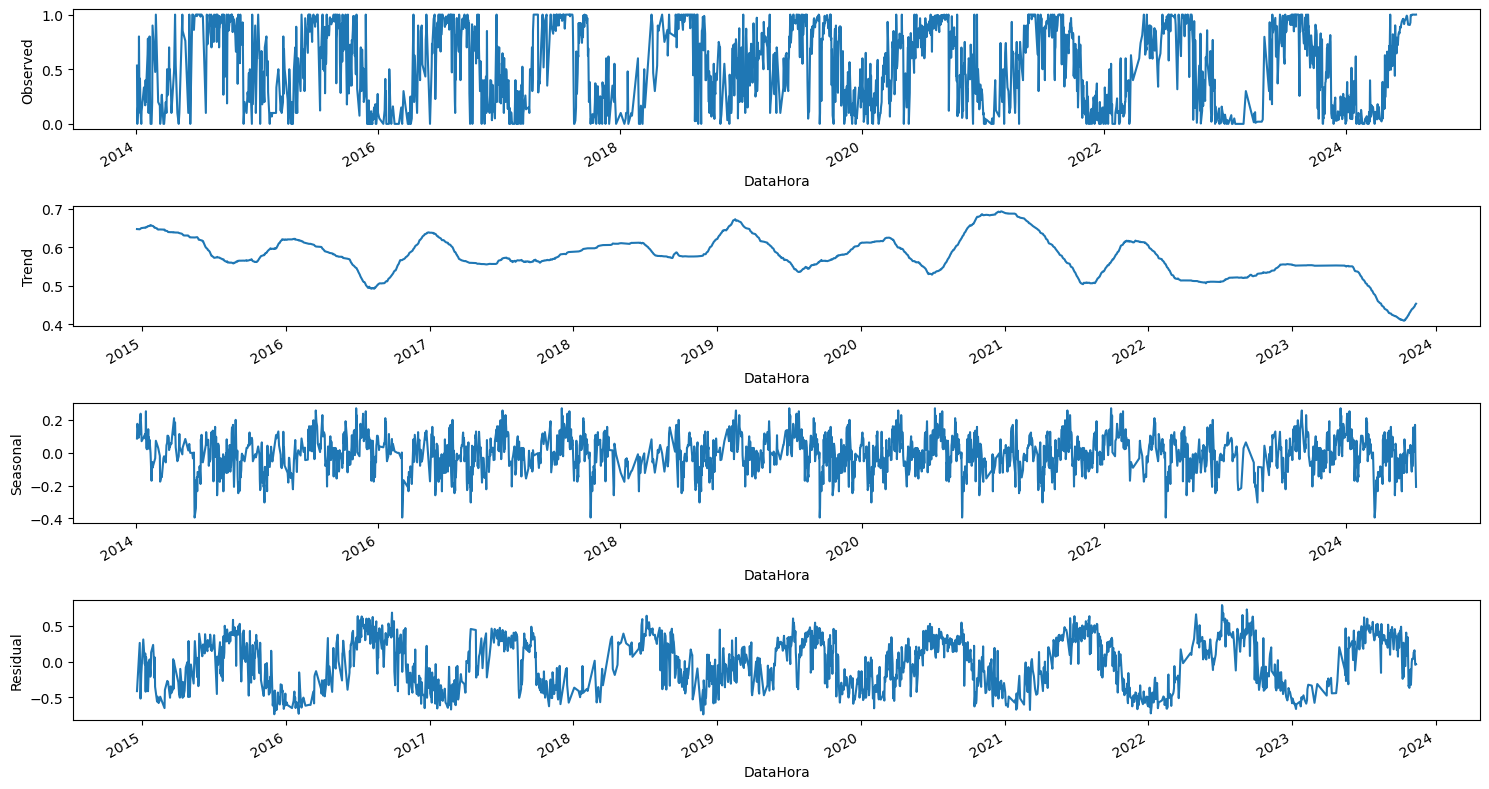

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Filtrando a série temporal para um bioma específico, por exemplo, 'Pantanal'
serie = base_dados[base_dados['Bioma'] == 'Pantanal'].set_index('DataHora')['RiscoFogo'].resample('D').mean()

# Decompondo a série temporal
decomposition = seasonal_decompose(serie.dropna(), model='additive', period=365)

# Plotando a decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()


## 1.2. Autocorrelação RiscoFogo na Pantanal 

In [7]:
# Filtrar os dados onde o Bioma é 'Pantanal'
filtro_caatinga = base_dados[base_dados['Bioma'] == 'Pantanal']

# Selecionar apenas a coluna 'RiscoFogo'
risco_fogo_caatinga = filtro_caatinga[['RiscoFogo']]
risco_fogo_caatinga

,RiscoFogo
519,0.1
520,0.8
523,0.0
527,0.2
537,1.0
...,...
1955378,1.0
1955379,1.0
1955380,1.0
1955399,1.0


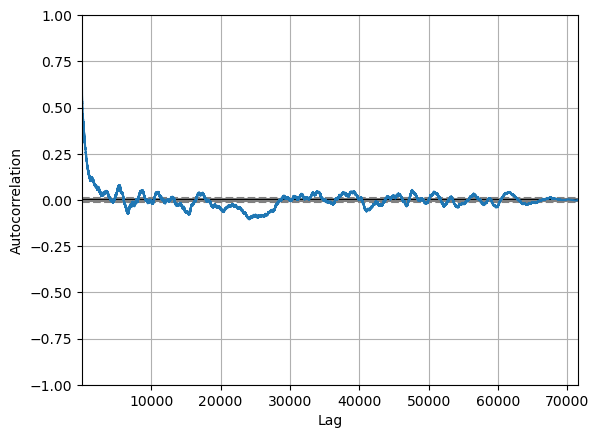

In [8]:
from pandas.plotting import autocorrelation_plot

# Gráfico de autocorrelação
autocorrelation_plot(risco_fogo_caatinga)
plt.show()

# 2. Modelos de Previsão

## 2.1. SARIMA

ADF Statistic: -5.728546128177775
p-value: 6.682898682430597e-07


c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, callin

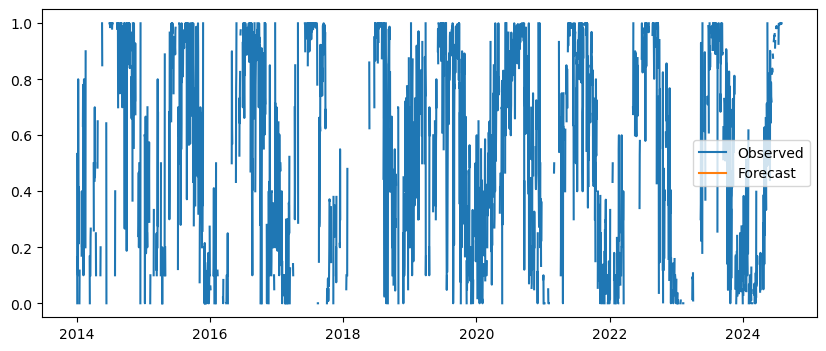

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Verificando estacionariedade
result = adfuller(serie.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Ajustando o modelo SARIMA
modelo_sarima = SARIMAX(serie.dropna(), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
resultado_sarima = modelo_sarima.fit(disp=False)

# Prevendo os próximos 30 dias
forecast = resultado_sarima.get_forecast(steps=30)
forecast_index = pd.date_range(start=serie.index[-1], periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotando a previsão
plt.figure(figsize=(10, 4))
plt.plot(serie, label='Observed')
plt.plot(forecast_series, label='Forecast')
plt.legend()
plt.show()

## 2.1. ARIMA

<h3>Análise de Anomalias com Isolation Forest</h3>
O Isolation Forest é um algoritmo de aprendizado de máquina para detectar anomalias. Vamos aplicar o Isolation Forest à coluna de interesse.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


In [11]:
# Função para verificar e definir a frequência
def definir_frequencia(serie, freq='D'):
    if serie.index.freq is None:
        print("Frequência não definida. Definindo a frequência como diária.")
        serie = serie.asfreq(freq)
    else:
        print(f"Frequência atual: {serie.index.freq}")
    return serie

# Função para verificar a estacionariedade
def verificar_estacionariedade(serie):
    result = adfuller(serie.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

# Função para ajustar o modelo ARIMA
def ajustar_modelo_arima(serie, p, d, q):
    modelo_arima = ARIMA(serie.dropna(), order=(p, d, q))
    resultado_arima = modelo_arima.fit()
    print(resultado_arima.summary())
    return resultado_arima

# Função para fazer previsões
def prever(modelo, passos):
    forecast = modelo.get_forecast(steps=passos)
    forecast_index = pd.date_range(start=serie.index[-1] + pd.Timedelta(days=1), periods=passos, freq='D')
    forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
    return forecast_series

# Função para plotar os resultados
def plotar_resultados(serie, forecast_series):
    plt.figure(figsize=(10, 6))
    plt.plot(serie, label='Observado')
    plt.plot(forecast_series, label='Previsão', color='red')
    plt.legend()
    plt.title('Previsão com Modelo ARIMA')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.show()

Frequência atual: <Day>
ADF Statistic: -5.728546128177775
p-value: 6.682898682430597e-07
A série é estacionária.


c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction r

                               SARIMAX Results                                
Dep. Variable:              RiscoFogo   No. Observations:                 2342
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 382.556
Date:                Tue, 13 Aug 2024   AIC                           -759.112
Time:                        13:59:35   BIC                           -741.837
Sample:                             0   HQIC                          -752.820
                               - 2342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1727      0.025      6.885      0.000       0.124       0.222
ma.L1         -0.7559      0.018    -41.442      0.000      -0.792      -0.720
sigma2         0.0422      0.001     51.804      0.0

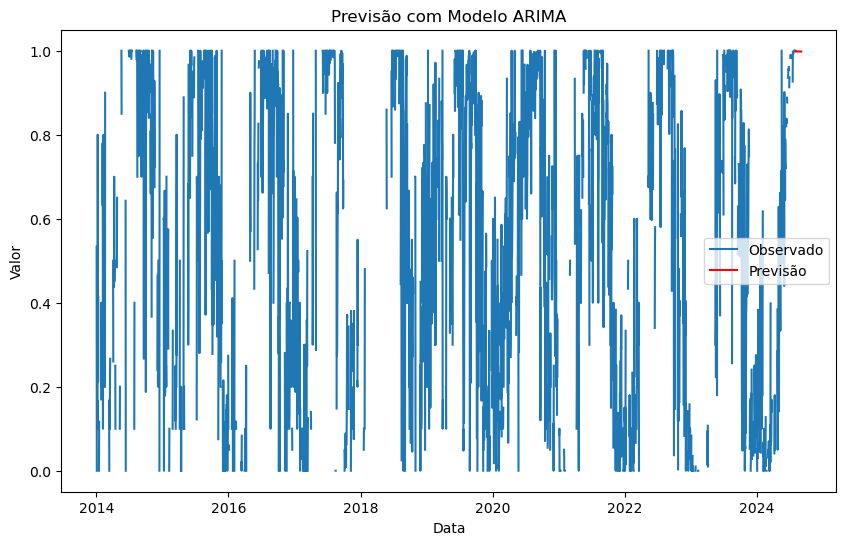

In [12]:
# Exemplo de uso
# Supondo que 'serie' seja o seu DataFrame com um índice de datas
# Definir a frequência
serie = definir_frequencia(serie, freq='D')

# Verificar a estacionariedade
verificar_estacionariedade(serie)

# Ajustar o modelo ARIMA com parâmetros p, d, q (ajustar conforme necessário)
resultado_arima = ajustar_modelo_arima(serie, p=1, d=1, q=1)

# Prever os próximos 30 dias
forecast_series = prever(resultado_arima, passos=30)

# Plotar os resultados
plotar_resultados(serie, forecast_series)


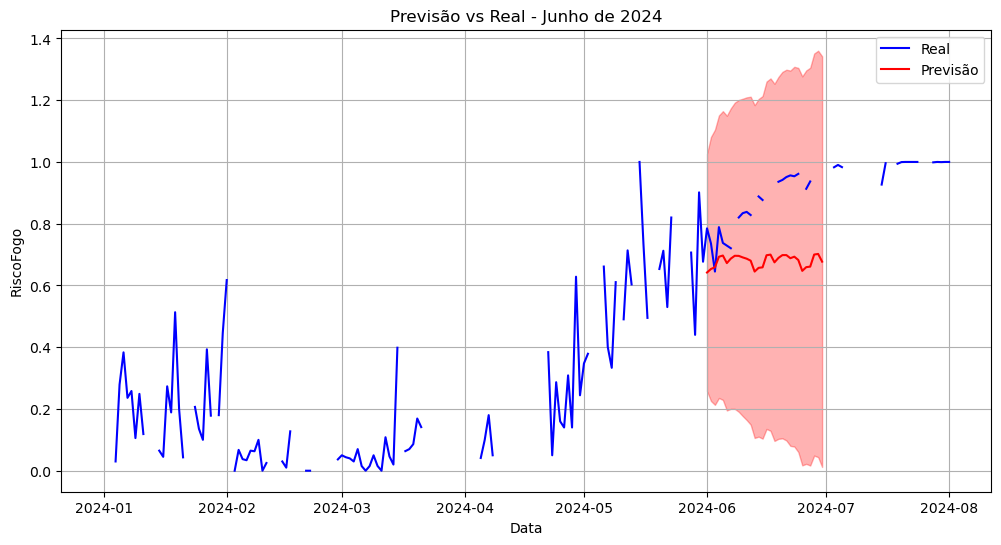

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Supondo que 'serie' é a sua série temporal com índice DatetimeIndex
# Separe a série em treinamento e teste
treinamento = serie[:'2024-05-31']
teste = serie['2024-06-01':'2024-06-30']

# Ajustar o modelo SARIMA
modelo_sarima = SARIMAX(treinamento, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
resultado_sarima = modelo_sarima.fit(disp=False)

# Prever o mês de junho de 2024
forecast = resultado_sarima.get_forecast(steps=30)
forecast_index = pd.date_range(start='2024-06-01', end='2024-06-30', freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
forecast_conf_int = forecast.conf_int()

# Plotar resultados para 2024
plt.figure(figsize=(12, 6))
plt.plot(serie['2024-01-01':'2024-12-31'], label='Real', color='blue')
plt.plot(forecast_series, label='Previsão', color='red')
plt.fill_between(forecast_series.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)
plt.legend()
plt.title('Previsão vs Real - Junho de 2024')
plt.xlabel('Data')
plt.ylabel('RiscoFogo')
plt.grid(True)
plt.show()


## 2.2. Modelos Espaciais Temporais 

In [14]:
import statsmodels.api as sm
from patsy import dmatrices

# Preparando os dados para a regressão
y, X = dmatrices('RiscoFogo ~ DiaSemChuva + Precipitacao', data=base_dados, return_type='dataframe')

# Ajustando o modelo
modelo_ols = sm.OLS(y, X).fit()

# Resumo do modelo
print(modelo_ols.summary())


                            OLS Regression Results                            
Dep. Variable:              RiscoFogo   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                 2.376e+05
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:59:43   Log-Likelihood:            -5.5335e+05
No. Observations:             1956208   AIC:                         1.107e+06
Df Residuals:                 1956205   BIC:                         1.107e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6854      0.000   2499.039   

## 2.3. Análise Multi Variada

Vamos verificar a correlação cruzada entre **Precipitacao** e **RiscoFogo**.

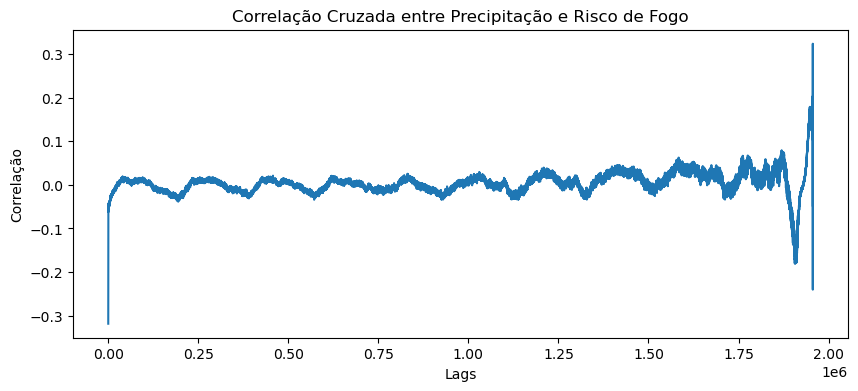

In [15]:
from statsmodels.tsa.stattools import ccf

# Calculando a correlação cruzada
precipitacao = base_dados['Precipitacao'].dropna()
risco_fogo = base_dados['RiscoFogo'].dropna()
ccf_vals = ccf(precipitacao, risco_fogo)

# Plotando a correlação cruzada
plt.figure(figsize=(10, 4))
plt.plot(ccf_vals)
plt.title('Correlação Cruzada entre Precipitação e Risco de Fogo')
plt.xlabel('Lags')
plt.ylabel('Correlação')
plt.show()


**Modelos de Regime Alternado**

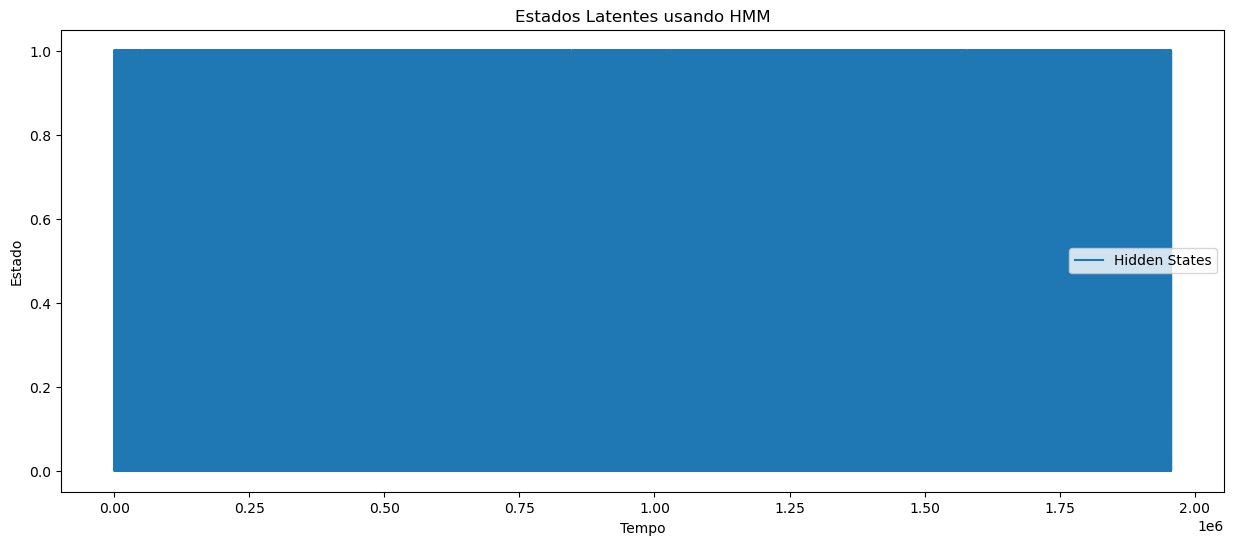

In [16]:
from hmmlearn.hmm import GaussianHMM

# Preparando os dados
data = base_dados[['DiaSemChuva', 'Precipitacao', 'RiscoFogo']].dropna().values

# Ajustando o modelo HMM
modelo_hmm = GaussianHMM(n_components=2, covariance_type='diag', n_iter=1000).fit(data)

# Prevendo os estados latentes
hidden_states = modelo_hmm.predict(data)

# Plotando os estados latentes
plt.figure(figsize=(15, 6))
plt.plot(hidden_states, label='Hidden States')
plt.title('Estados Latentes usando HMM')
plt.xlabel('Tempo')
plt.ylabel('Estado')
plt.legend()
plt.show()


## 2.4. Detecção de Anomalias

<h3>Detecção de Mudanças com CUSUM</h3>

O CUSUM (Cumulative Sum Control Chart) é uma técnica para detectar mudanças em uma série temporal. Você pode usar a biblioteca statsmodels para aplicar CUSUM. Aqui está um exemplo de como fazer isso:

In [17]:
base_dados = pd.read_csv('dados_limpos_v4.csv')
base_dados['DataHora'] = pd.to_datetime(base_dados['DataHora'])

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW

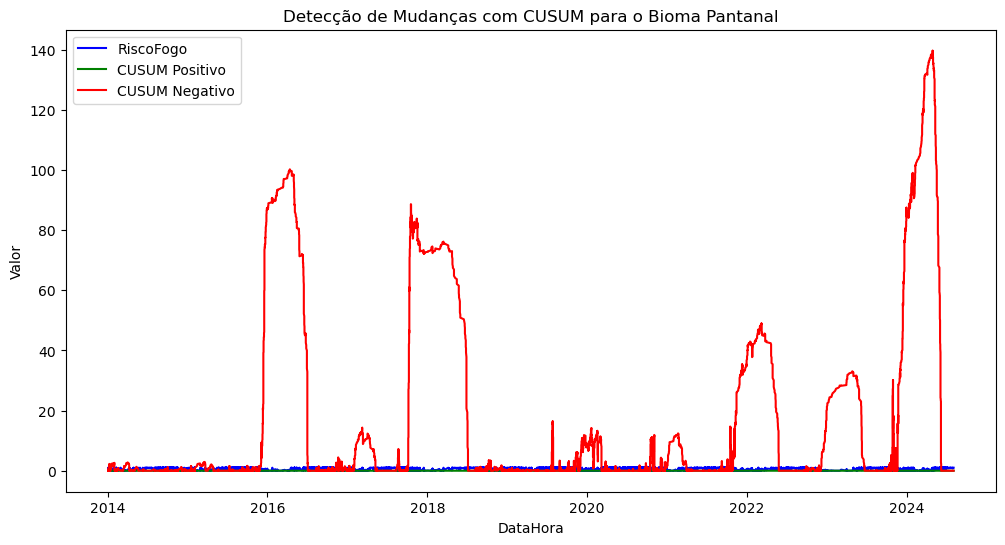

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supondo que o DataFrame seja chamado base_dados
# Filtrar o DataFrame para o bioma da Pantanal
caatinga_dados = base_dados[base_dados['Bioma'] == 'Pantanal']

# Ordenar pelos horários para garantir que a série temporal esteja ordenada
caatinga_dados = caatinga_dados.sort_values(by='DataHora')

# Definir a série temporal para a coluna 'RiscoFogo'
series = caatinga_dados.set_index('DataHora')['RiscoFogo'].dropna()

# Função de detecção de anomalias CUSUM
def cusum_detection(series, threshold=0.5):
    mean = series.mean()
    std_dev = series.std()
    cusum_pos = np.zeros(len(series))
    cusum_neg = np.zeros(len(series))
    
    for i in range(1, len(series)):
        cusum_pos[i] = max(0, cusum_pos[i-1] + (series.iloc[i] - mean - threshold))
        cusum_neg[i] = max(0, cusum_neg[i-1] + (mean - series.iloc[i] - threshold))
        
    return cusum_pos, cusum_neg

# Aplicar a função de detecção de anomalias
cusum_pos, cusum_neg = cusum_detection(series)

# Plotar o resultado
plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values, label='RiscoFogo', color='blue')
plt.plot(series.index, cusum_pos, label='CUSUM Positivo', color='green')
plt.plot(series.index, cusum_neg, label='CUSUM Negativo', color='red')
plt.title('Detecção de Mudanças com CUSUM para o Bioma Pantanal')
plt.xlabel('DataHora')
plt.ylabel('Valor')
plt.legend()
plt.show()


<h3>Análise de Anomalias com Isolation Forest</h3>
O Isolation Forest é um algoritmo de aprendizado de máquina para detectar anomalias. Vamos aplicar o Isolation Forest à coluna de interesse.

c:\Users\gustavo.j.siebel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


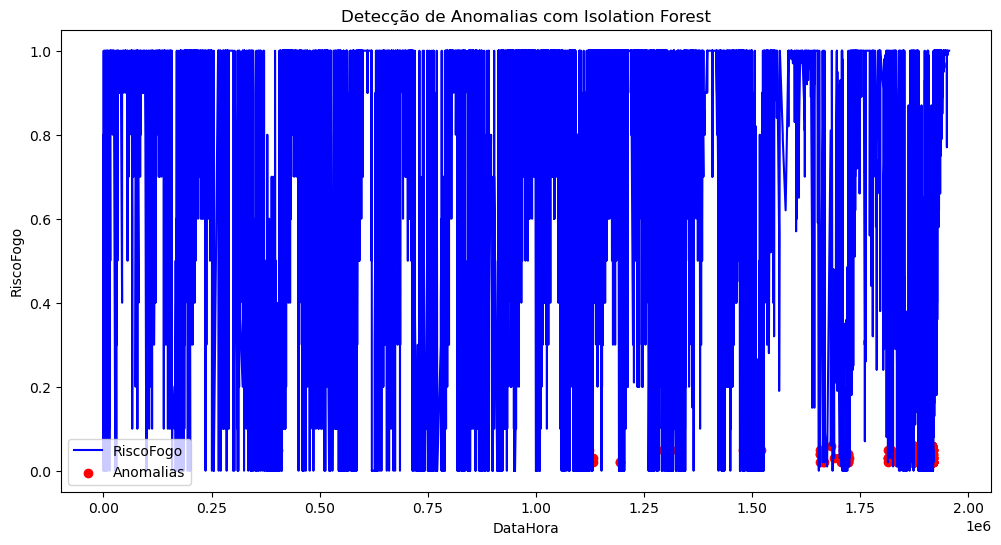

In [20]:
from sklearn.ensemble import IsolationForest

# Usando a coluna 'RiscoFogo' para detectar anomalias
data = caatinga_dados[['RiscoFogo']].dropna()

# Treinando o modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.01)  # Ajuste a contaminação conforme necessário
data['Anomaly'] = iso_forest.fit_predict(data[['RiscoFogo']])

# Marcando os valores anômalos
anomalies = data[data['Anomaly'] == -1]

# Plotando o resultado
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RiscoFogo'], label='RiscoFogo', color='blue')
plt.scatter(anomalies.index, anomalies['RiscoFogo'], color='red', label='Anomalias')
plt.title('Detecção de Anomalias com Isolation Forest')
plt.xlabel('DataHora')
plt.ylabel('RiscoFogo')
plt.legend()
plt.show()


## 2.5. SARIMAX

                                     SARIMAX Results                                      
Dep. Variable:                          RiscoFogo   No. Observations:                  128
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  40.543
Date:                            Tue, 13 Aug 2024   AIC                            -71.086
Time:                                    14:00:13   BIC                            -57.361
Sample:                                01-31-2014   HQIC                           -65.515
                                     - 08-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3528      0.103      3.431      0.001       0.151       0.554
ma.L1         -0.9969      0.594   

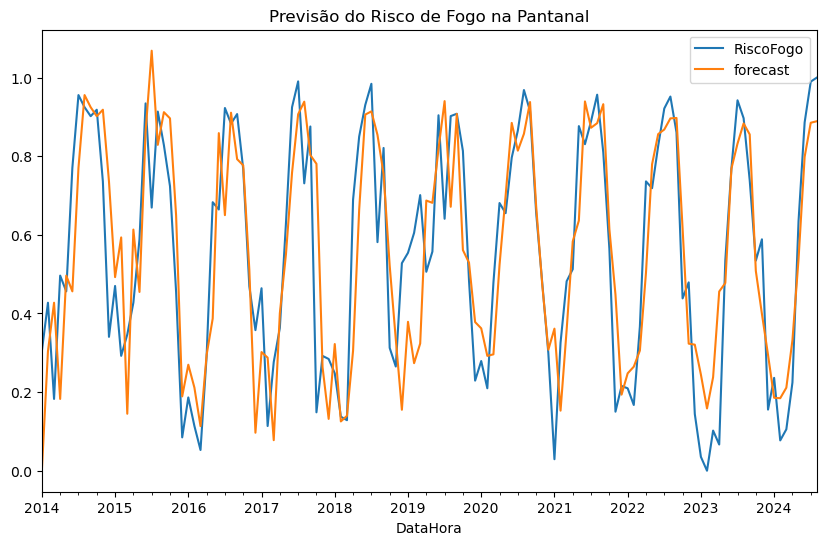

In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Criando um DataFrame focado em um bioma específico
bioma_especifico = base_dados[base_dados['Bioma'] == 'Pantanal']

# Definindo 'DataHora' como índice para poder usar o resample
bioma_especifico = bioma_especifico.set_index('DataHora')

# Fazendo a agregação por mês, calculando a média apenas para colunas numéricas
monthly_data = bioma_especifico.resample('M').mean(numeric_only=True)

# Aplicando um modelo SARIMA como proxy de um modelo STVAR
model = sm.tsa.statespace.SARIMAX(monthly_data['RiscoFogo'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Resumo do modelo
print(results.summary())

# Previsão
monthly_data['forecast'] = results.predict(start=0, end=len(monthly_data)-1, dynamic=False)

# Plotando os resultados
monthly_data[['RiscoFogo', 'forecast']].plot(figsize=(10, 6))
plt.title('Previsão do Risco de Fogo na Pantanal')
plt.show()


## 2.6. Modelo VAR (Vector AutoRegression)

#### **1. Fórmula Geral do Modelo VAR**

Para um sistema com \( k \) variáveis e \( p \) defasagens, o modelo VAR é expresso como:

\[ 
Y_t = C + \Phi_1 Y_{t-1} + \Phi_2 Y_{t-2} + \cdots + \Phi_p Y_{t-p} + \varepsilon_t 
\]

Onde:

- \( Y_t \) é um vetor \( k \times 1 \) de variáveis no tempo \( t \).
- \( C \) é um vetor \( k \times 1 \) de interceptos constantes.
- \( \Phi_i \) (para \( i = 1, 2, \ldots, p \)) são matrizes \( k \times k \) de coeficientes para as defasagens.
- \( \varepsilon_t \) é um vetor \( k \times 1 \) de termos de erro, assumidos como ruído branco com média zero e variância constante.

#### **2. Parâmetros Selecionados**
##### **a. Variáveis no Modelo**

- **`RiscoFogo`**: Representa o risco de fogo, uma das variáveis de interesse.
- **`Precipitacao`**: Representa a precipitação, que pode influenciar o risco de fogo.
- **`DiaSemChuva`**: Representa a presença ou ausência de chuva, outra variável relevante.
- **`Latitude`** e **`Longitude`**: Coordenadas geográficas que podem ajudar a capturar padrões espaciais.
  
Para o modelo VAR, usamos um subconjunto dessas variáveis para capturar a dinâmica entre elas. No código, essas variáveis foram selecionadas com base na relevância para a análise e na presença de dados.

##### **b. Parâmetros do Modelo**

- **Defasagens (\( p \))**: O número de defasagens especifica quantos períodos anteriores são considerados no modelo. No exemplo, \( p = 5 \) foi escolhido. Esse valor é ajustável com base na análise dos dados e nos critérios de seleção.

- **Matrizes de Coeficientes (\( \Phi_i \))**: Cada matriz \( \Phi_i \) representa a influência das defasagens das variáveis na variável dependente. Por exemplo, \( \Phi_1 \) captura o efeito das variáveis no período anterior (\( t-1 \)).

- **Intercepto (\( C \))**: Representa o valor médio das variáveis quando todas as defasagens são zero. É uma constante adicionada ao modelo para ajustar a média.

- **Termos de Erro (\( \varepsilon_t \))**: São os resíduos do modelo, representando a parte do valor da variável que não é explicada pelas defasagens e os coeficientes. Estes são assumidos como ruído branco, ou seja, com média zero e variância constante.

#### **3. Uso dos Parâmetros no Modelo**

No modelo VAR:

- As **defasagens** (ou lags) são usadas para capturar as dependências temporais entre as variáveis. Por exemplo, a defasagem de 1 período ( \( Y_{t-1} \) ) mostra como o valor passado das variáveis afeta o valor atual.
  
- As **matrizes de coeficientes** (\( \Phi_i \)) são ajustadas para minimizar a diferença entre os valores previstos e os valores reais. Elas mostram a força e a direção das relações entre as variáveis.

- O **intercepto** (\( C \)) ajuda a modelar o nível base das variáveis.

- Os **termos de erro** (\( \varepsilon_t \)) capturam qualquer variação não explicada pelas variáveis e defasagens incluídas no modelo.

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, Aug, 2024
Time:                     14:00:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.909830
Nobs:                     124.000    HQIC:                  0.383136
Log likelihood:          -490.259    FPE:                    1.02544
AIC:                    0.0228056    Det(Omega_mle):        0.760353
--------------------------------------------------------------------
Results for equation Precipitacao
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   2.193185         0.636205            3.447           0.001
L1.Precipitacao        -0.013130         0.102210           -0.128           0.898
L1.DiaSemChuva         -0.001535         0.02

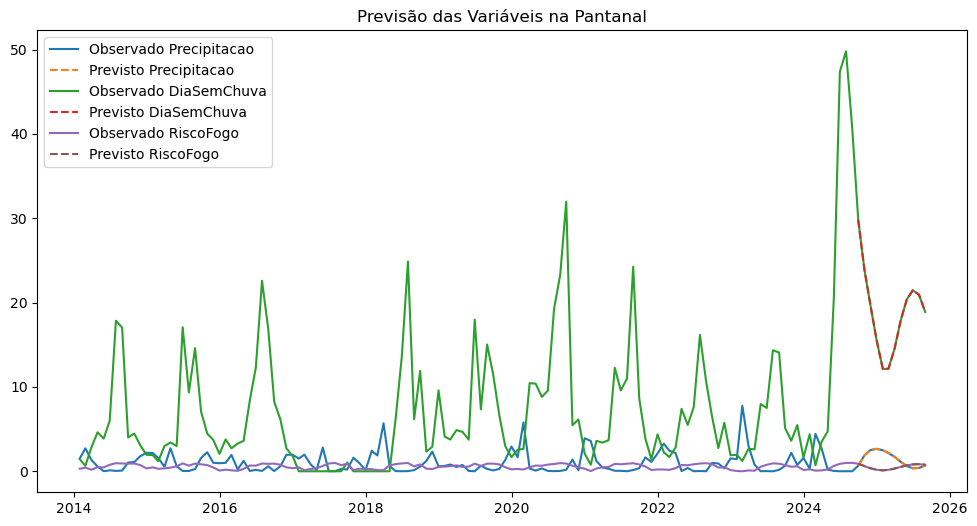

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Suponha que seu DataFrame seja chamado 'base_dados'
# Foco em um bioma específico, por exemplo, 'Pantanal'
bioma_especifico = base_dados[base_dados['Bioma'] == 'Pantanal'].copy()

# Definir 'DataHora' como índice e garantir que está no formato datetime
bioma_especifico['DataHora'] = pd.to_datetime(bioma_especifico['DataHora'])
bioma_especifico = bioma_especifico.set_index('DataHora')

# Selecionar colunas relevantes
variaveis = bioma_especifico[['Precipitacao', 'DiaSemChuva', 'RiscoFogo']].copy()

# Remover linhas com valores NaN
variaveis = variaveis.dropna()

# Agregar dados por mês
monthly_data = variaveis.resample('M').mean()

# Ajustar um modelo VAR
model = VAR(monthly_data)
results = model.fit(maxlags=15, ic='aic')  # Ajuste o número de lags conforme necessário

# Resumo do modelo
print(results.summary())

# Fazer previsões
forecast_steps = 12
forecast = results.forecast(monthly_data.values[-results.k_ar:], steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=monthly_data.columns)

# Adicionar previsões ao DataFrame original
extended_data = pd.concat([monthly_data, forecast_df])

# Plotar resultados
plt.figure(figsize=(12, 6))
for column in monthly_data.columns:
    plt.plot(extended_data.index, extended_data[column], label=f'Observado {column}')
    plt.plot(forecast_df.index, forecast_df[column], linestyle='--', label=f'Previsto {column}')

plt.title('Previsão das Variáveis na Pantanal')
plt.legend()
plt.show()
